In [1]:
from google.colab import drive

#Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

1. Data Preprocessing


In [3]:
# Load the data
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/RCM/data.csv")

In [4]:
# Display the data
data.head()

,username,rating,rating_time,item_id
0,l*****.,5.0,1.702872e+09,21192160813
1,kokoromiinah,5.0,1.702987e+09,21192160813
2,h*****2,5.0,1.704507e+09,21192160813
3,khanhlinh01011998,5.0,1.704717e+09,21192160813
4,julietran3036,5.0,1.704356e+09,21192160813


In [5]:
# Shape of the data
data.shape

(121399, 4)

In [6]:
# Convert "item_id" into str
data['item_id'] = data['item_id'].astype(str)

In [7]:
# Check the datatypes
data.dtypes

username        object
rating         float64
rating_time    float64
item_id         object
dtype: object

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121399 entries, 0 to 121398
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   username     120473 non-null  object 
 1   rating       121399 non-null  float64
 2   rating_time  121399 non-null  float64
 3   item_id      121399 non-null  object 
dtypes: float64(2), object(2)
memory usage: 3.7+ MB


In [9]:
data.describe()['rating']

count    121399.000000
mean          4.870114
std           0.537541
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [10]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(data.rating.min()))
print('Maximum rating is: %d' %(data.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [11]:
# Check for missing values
print('Number of missing values across columns: \n'), data.isnull().sum()

Number of missing values across columns: 



(None,
 username       926
 rating           0
 rating_time      0
 item_id          0
 dtype: int64)

In [12]:
# Drop rows with missing values in the specified columns
columns_to_check = ['username', 'rating', 'rating_time', 'item_id']
data = data.dropna(subset=columns_to_check)

# Display the DataFrame after dropping rows with missing values in the specified columns
print("DataFrame after dropping rows with missing values in specified columns:")
print(data)

DataFrame after dropping rows with missing values in specified columns:
                 username  rating   rating_time      item_id
0                 l*****.     5.0  1.702872e+09  21192160813
1            kokoromiinah     5.0  1.702987e+09  21192160813
2                 h*****2     5.0  1.704507e+09  21192160813
3       khanhlinh01011998     5.0  1.704717e+09  21192160813
4           julietran3036     5.0  1.704356e+09  21192160813
...                   ...     ...           ...          ...
121394              skt86     5.0  1.667826e+09  19751058694
121395       khoauong1992     1.0  1.672741e+09  19751058694
121396        huong484557     2.0  1.667911e+09  19751058694
121397    minhtrung190619     5.0  1.675754e+09  19751058694
121398         station_18     5.0  1.669523e+09  19751058694

[120473 rows x 4 columns]


In [13]:
# Check for missing values after dropping
print('Number of missing values across columns: \n'), data.isnull().sum()

Number of missing values across columns: 



(None,
 username       0
 rating         0
 rating_time    0
 item_id        0
 dtype: int64)

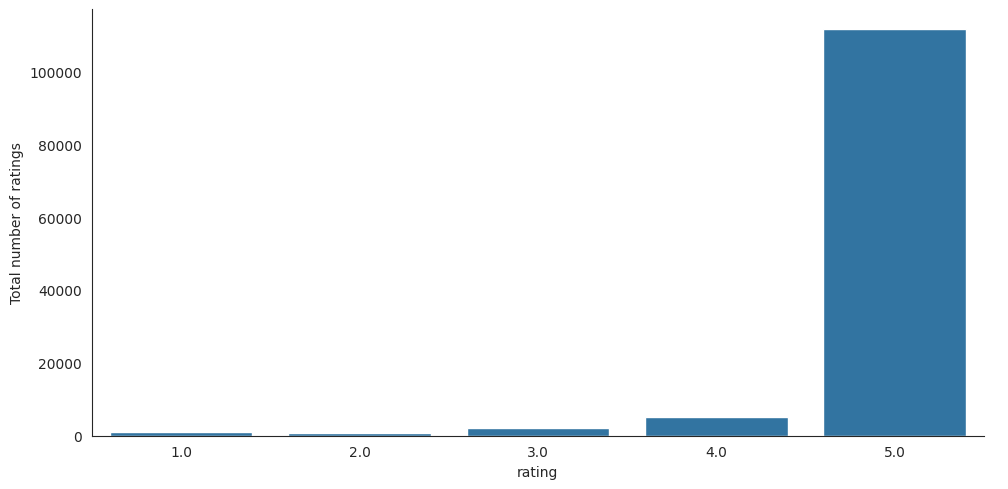

In [14]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x="rating", data=data, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

plt.show()

In [15]:
# Check unque users and products
print("Total no of ratings :",data.shape[0])
print("Total No of Users   :", len(np.unique(data.username)))
print("Total No of products  :", len(np.unique(data.item_id)))

Total no of ratings : 120473
Total No of Users   : 86561
Total No of products  : 599


In [16]:
data.drop(['rating_time'], axis=1,inplace=True)

In [17]:
# Analysis of rating given by the user
no_of_rated_products_per_user = data.groupby(by='username')['rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

username
t*****1    347
t*****2    338
n*****2    336
t*****4    319
n*****1    306
Name: rating, dtype: int64

In [18]:
no_of_rated_products_per_user.describe()

count    86561.000000
mean         1.391770
std          5.793244
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        347.000000
Name: rating, dtype: float64

In [19]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 149



2. Popularity Based Recommendation

In [20]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=data.groupby("item_id").filter(lambda x:x['rating'].count() >=50)

In [21]:
new_df

,username,rating,item_id
32,e*****8,5.0,22422234055
33,c*****w,5.0,22422234055
34,phamthiennhi_1008,5.0,22422234055
35,phmnguynthonguyn020,5.0,22422234055
36,yukenz,5.0,22422234055
...,...,...,...
121394,skt86,5.0,19751058694
121395,khoauong1992,1.0,19751058694
121396,huong484557,2.0,19751058694
121397,minhtrung190619,5.0,19751058694


Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-100.0, 0, ''),
 Text(0.0, 0, ''),
 Text(100.0, 0, ''),
 Text(200.0, 0, ''),
 Text(300.0, 0, ''),
 Text(400.0, 0, ''),
 Text(500.0, 0, '')]

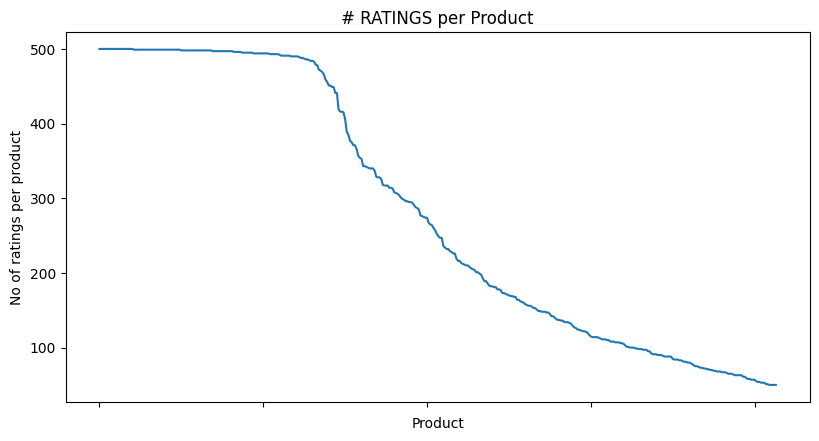

In [22]:
no_of_ratings_per_product = new_df.groupby(by='item_id')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [23]:
#Average rating of the product

new_df.groupby('item_id')['rating'].mean().sort_values(ascending=False).head()

item_id
20690679541    5.000000
14666309736    5.000000
23334535330    5.000000
23703190116    5.000000
20577760962    4.997972
Name: rating, dtype: float64

In [24]:
#Total no of rating for product

new_df.groupby('item_id')['rating'].count().sort_values(ascending=False).head()

item_id
18483274744    500
21326754089    500
23477679701    500
20606812586    500
23980810145    500
Name: rating, dtype: int64

In [25]:
ratings_mean_count = pd.DataFrame(new_df.groupby('item_id')['rating'].mean())

In [26]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('item_id')['rating'].count())

In [27]:
ratings_mean_count.head()

,rating,rating_counts
item_id,,
10089228676,4.909677,155
1028169351,4.867617,491
10334777266,4.882353,51
10487449517,4.865462,498
10503756045,4.970588,68


In [28]:
ratings_mean_count['rating_counts'].max()

500

<Figure size 800x600 with 0 Axes>

<Axes: >

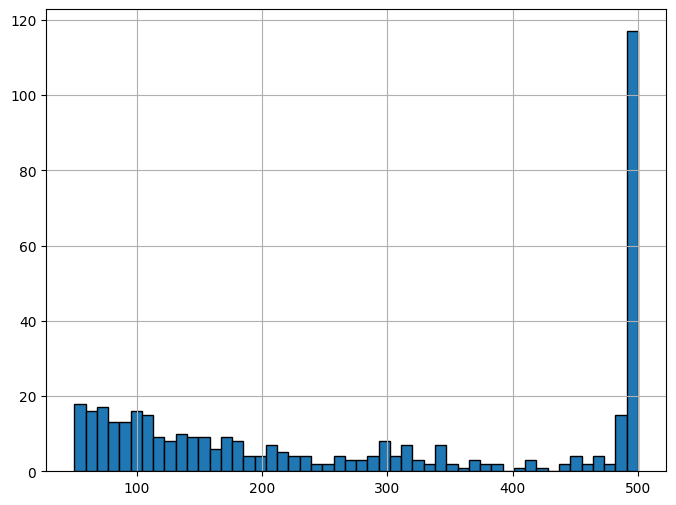

In [29]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Axes: >

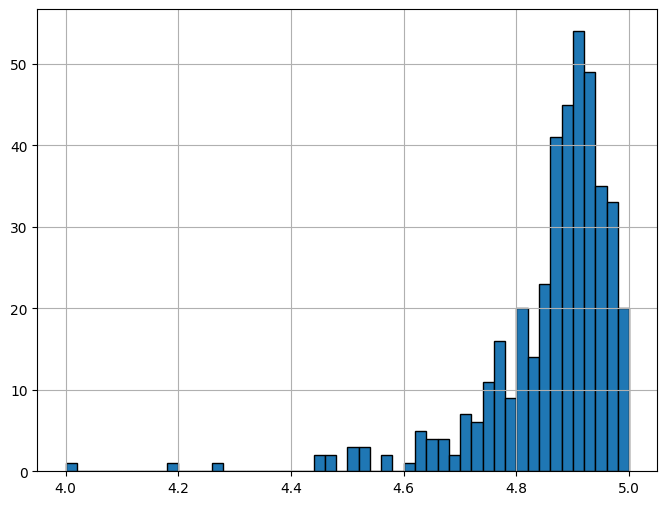

In [30]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

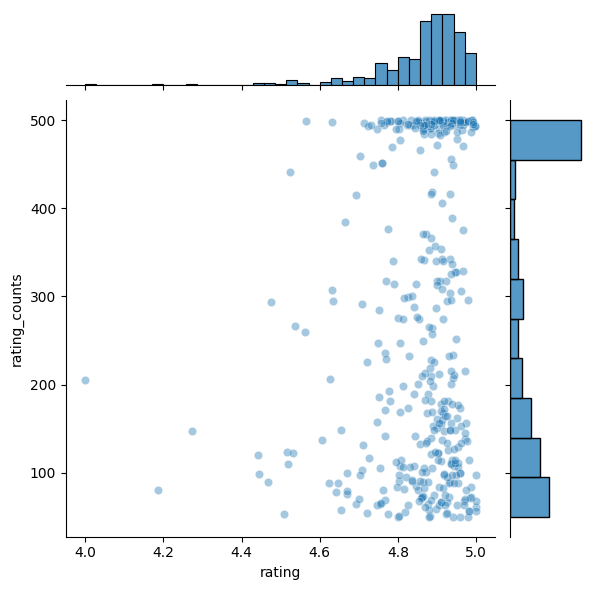

In [31]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<Axes: xlabel='item_id'>

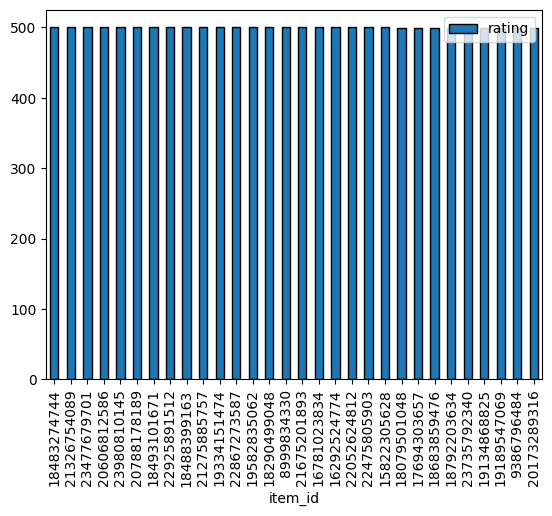

In [32]:
popular_products = pd.DataFrame(new_df.groupby('item_id')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

3. Collaberative filtering (Item-Item recommedation)

In [33]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162671 sha256=843f1d97c7214fb1b568eb0b58241784a7e735ba71c0e2596661cf6d33365dce
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [34]:
new_df.to_csv('new_df.csv', index=False)
new_df

,username,rating,item_id
32,e*****8,5.0,22422234055
33,c*****w,5.0,22422234055
34,phamthiennhi_1008,5.0,22422234055
35,phmnguynthonguyn020,5.0,22422234055
36,yukenz,5.0,22422234055
...,...,...,...
121394,skt86,5.0,19751058694
121395,khoauong1992,1.0,19751058694
121396,huong484557,2.0,19751058694
121397,minhtrung190619,5.0,19751058694


In [35]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RCM/new_df.csv')
df

,username,rating,item_id
0,e*****8,5.0,22422234055
1,c*****w,5.0,22422234055
2,phamthiennhi_1008,5.0,22422234055
3,phmnguynthonguyn020,5.0,22422234055
4,yukenz,5.0,22422234055
...,...,...,...
116942,skt86,5.0,19751058694
116943,khoauong1992,1.0,19751058694
116944,huong484557,2.0,19751058694
116945,minhtrung190619,5.0,19751058694


In [36]:
from surprise import KNNWithMeans
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Reading the dataset
reader = Reader(rating_scale=(1, 5))
#data = Dataset.load_from_df(new_df, reader)
data = Dataset.load_from_df(df, reader)

# Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

# Collaborative Filtering using KNN
algo_collaborative = KNNWithMeans(k=20, sim_options={'name': 'cosine', 'user_based': False})
algo_collaborative.fit(trainset)

# Matrix Factorization using TruncatedSVD
#ratings_matrix = new_df.pivot_table(values='rating', index='username', columns='item_id', fill_value=0)
ratings_matrix = df.pivot_table(values='rating', index='username', columns='item_id', fill_value=0)
X = ratings_matrix.T
SVD = TruncatedSVD(n_components=20)
decomposed_matrix = SVD.fit_transform(X)
correlation_matrix = np.corrcoef(decomposed_matrix)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [37]:
# Combine both approaches for recommendations
def get_recommendations(item_id):
    # Collaborative Filtering
    test_pred = algo_collaborative.predict('user_id', item_id)
    collaborative_score = test_pred.est

    # Item-based Matrix Factorization
    product_names = list(X.index)
    product_ID = product_names.index(item_id)
    correlation_product_ID = correlation_matrix[product_ID]
    item_based_recommendations = list(X.index[correlation_product_ID > 0.6])
    item_based_recommendations.remove(item_id)

    # Combined Score (you can adjust weights based on your preference)
    combined_score = 0.7 * collaborative_score + 0.3 * len(item_based_recommendations)

    return combined_score, item_based_recommendations[:10]

In [38]:
# Example recommendation for a product (replace 'i' with a valid product ID)
recommended_score, recommendations = get_recommendations(10089228676)
# Print recommendations
print("Combined Recommendations:")
print("Score:", recommended_score)
print("Recommendations:", recommendations)

Combined Recommendations:
Score: 68.89999999999999
Recommendations: [1604866573, 1655126512, 2106757987, 2137079016, 2505538672, 2644582776, 2885370522, 3094089946, 3184502848, 3358706204]
